# Run DEMO

In [1]:
#https://kb.oakland.edu/uts/HPCJupyterMPI
import ipyparallel as ipp

In [2]:
def mpi_code():
    from mpi4py import MPI
    import tensair_py
    import os
    comm = MPI.COMM_WORLD
    tensair_path = os.environ.get("TENSAIR_PATH")

    mini_batch_size = 128
    msg_sec = 200    
    init_code= tensair_path + "/Examples/Demo_Init.py"
    event_generator = tensair_py.UDF_EventGenerator(mpi_comm=comm, tag=1, mini_batch_size=mini_batch_size, msg_sec=msg_sec, init_code=init_code)

    inputMaxSize = 4+4+ (8*2) + (4*mini_batch_size) + (4*mini_batch_size*32*32*3)
    gradientsMaxSize = 8+4+4+4+4+(8*12) + (4*((64*10) + (10) + (3*3*3*32) + (32) + (3*3*32*64) + (64) + (3*3*64*64) + (64) + (1024*64) + (64)))
    window_size = max(inputMaxSize, gradientsMaxSize)
    saved_model_dir = tensair_path + "/data/demo/cifar_model_demo.tf"  #Created using DEMO-Model notebook
    model = tensair_py.TensAIR(mpi_comm=comm, tag=2, window_size=window_size, saved_model_dir=saved_model_dir)

    drift_detector = tensair_py.OPTWIN_drift_detector(mpi_comm=comm, tag=3)

    operators = [event_generator, model, drift_detector]
    links = [[0,1],[1,1],[1,2],[2,1]]
    basic_dataflow = tensair_py.BasicDataflow(mpi_comm=comm, operators=operators, links=links)
    print("Starting dataflow")
    basic_dataflow.streamProcess()


In [3]:
rc = ipp.Cluster(controller_ip="*", engines="mpi", n=2).start_and_connect_sync()

Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/2 [00:00<?, ?engine/s]

In [4]:
view = rc.broadcast_view()

In [5]:
ar_list = [view.apply_async(mpi_code, 2)]

In [6]:
asyn_run = view.apply_async(mpi_code)

In [7]:
asyn_run

<AsyncResult(mpi_code): pending>

# Visualize Results

The visualization does not work on jupyter lab, only on jupyter notebook

In [16]:
%matplotlib ipympl
from itertools import count
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
import os

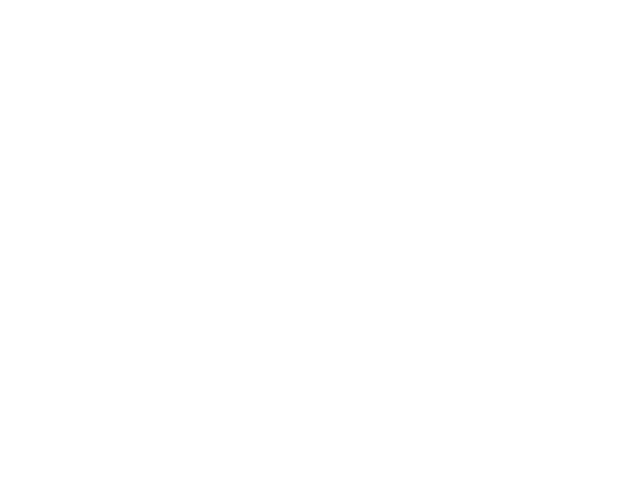

In [17]:
index = count()
losses = []
accs = []
conditions = []
conditions_first = {'blue': True, 'red': True}
wainting_file = True

tensair_path = os.environ.get("TENSAIR_PATH")
outputfile = tensair_path + "/output/0.csv"


while(wainting_file):
    try: 
        myfile = open(outputfile, "r")
        wainting_file = False
    except:
        time.sleep(1)
    
def animate(i):
    global losses, conditions
    while True:
        line = myfile.readline()
        if line != "":
            parts = line.split(',')
            losses.append(float(parts[2]))
            conditions.append(parts[0])  # Assume this is the condition
        else:
            break

    plt.cla()  # Clear the axes to avoid drawing over the old lines

    # Plot each segment with a color based on the condition
    for j in range(1, len(losses)):
        color = 'blue' if conditions[j] == 'training' else 'red'
        if conditions_first[color]:
            plt.plot([j-1, j], [losses[j-1], losses[j]], color=color, label=conditions[j])
            conditions_first[color] = False
        else:
            plt.plot([j-1, j], [losses[j-1], losses[j]], color=color)
            
    plt.xlabel('datastream')
    plt.ylabel('Loss')
    plt.legend(loc='upper left', shadow=True, fontsize='large')

            
ani = FuncAnimation(plt.gcf(), animate, interval=1000)

plt.show()

In [21]:
index = count()
losses = []
accs = []
conditions = []
conditions_first = {'blue': True, 'red': True}
wainting_file = True

tensair_path = os.environ.get("TENSAIR_PATH")
outputfile = tensair_path + "/output/0.csv"


while(wainting_file):
    try: 
        myfile = open(outputfile, "r")
        wainting_file = False
    except:
        time.sleep(1)
        
while True:
    try:
        line = myfile.readline()
        if line != "":
            parts = line.split(',')
            losses.append(float(parts[2]))
            conditions.append(parts[0])  # Assume this is the condition
        else:
            break     
    except:
        break


ERROR:tornado.application:Exception in callback <bound method TimerBase._on_timer of <matplotlib.backends.backend_webagg_core.TimerTornado object at 0x12f5bd070>>
Traceback (most recent call last):
  File "/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packages/tornado/ioloop.py", line 921, in _run
    val = self.callback()
  File "/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packages/matplotlib/backend_bases.py", line 1193, in _on_timer
    ret = func(*args, **kwargs)
  File "/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packages/matplotlib/animation.py", line 1404, in _step
    still_going = super()._step(*args)
  File "/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packages/matplotlib/animation.py", line 1097, in _step
    self._draw_next_frame(framedata, self._blit)
  File "/Users/mauro.dalleluccatosi/Documents/environments/tensair/lib/python3.9/site-packag

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


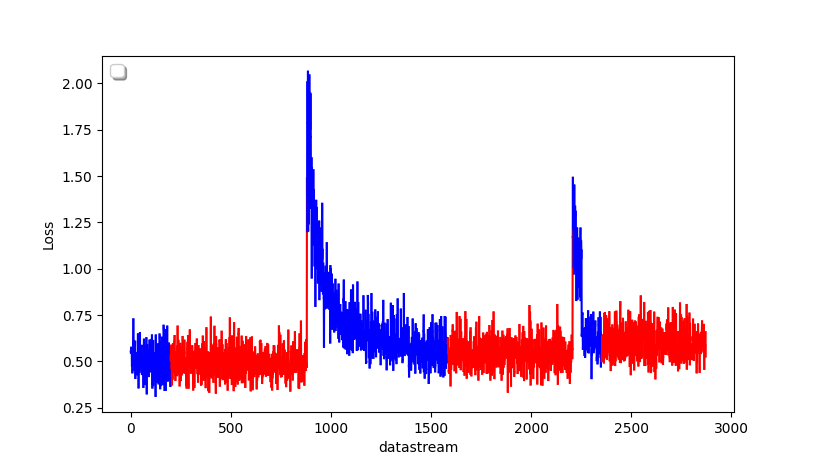

In [28]:
plt.cla()  # Clear the axes to avoid drawing over the old lines
for j in range(1, len(losses)):
    color = 'blue' if conditions[j] == 'training' else 'red'
    if conditions_first[color]:
        plt.plot([j-1, j], [losses[j-1], losses[j]], color=color, label=conditions[j])
        conditions_first[color] = False
    else:
        plt.plot([j-1, j], [losses[j-1], losses[j]], color=color)

plt.xlabel('datastream')
plt.ylabel('Loss')
plt.legend(loc='upper left', shadow=True, fontsize='large')
plt.show()

In [ ]:
import matplotlib
matplotlib.use('Qt5Agg')  # Or 'Qt5Agg', or 'WXAgg'


plt.cla()  # Clear the axes to avoid drawing over the old lines

# Initialize variables to track whether each condition has appeared for the first time
conditions_first = {'blue': True, 'red': True}

losses = [0.1, 0.2, 0.3, 0.2, 0.1]
conditions = ['training', 'testing', 'training', 'testing', 'training']

for j in range(1, len(losses)):
    color = 'blue' if conditions[j] == 'training' else 'red'
    if conditions_first[color]:
        plt.plot([j-1, j], [losses[j-1], losses[j]], color=color, label=conditions[j])
        conditions_first[color] = False
    else:
        plt.plot([j-1, j], [losses[j-1], losses[j]], color=color)

plt.xlabel('datastream')
plt.ylabel('Loss')
plt.legend(loc='upper left', shadow=True, fontsize='large')

# Print out the legend labels
print("Legend Labels:", [text.get_text() for text in plt.gca().get_legend().get_texts()])

plt.show()


In [ ]:
#ani.pause()